# **Lightgbm and XGboost** 

- In the following excercise we are going to apply a GBM, LightGBM and XGboot to a property price prediction, using open data you can find [here](https://www.properati.com.co/data). In this case we are going to use data from Argentina.

# Data preprocessing 

In [1]:
import lightgbm 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('ar_properties.csv')

- We are going to use only the data from aparments and we are going to predict only sell price, not rent price

In [3]:
data=data[data['operation_type']=='Venta']

In [4]:
data.groupby('currency').agg({'id':'count'})

,id
currency,
ARS,21904
COP,2
PEN,168
USD,696626
UYU,3


- As we can see here, we have data from aparment prices in diferent currencys. For the simplicity of the excercise we are going to leave only the aparments that are being sold in ARS

In [5]:
data=data[data['currency']=='ARS']

In [6]:
data.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

- We need to transform the categorical variables to dummies, and in this especific case we are goint yo normalize uor data

In [7]:
data=data.drop(columns=['l1', 'l2', 'l3', 'l4','ad_type','start_date', 'end_date','created_on','price_period','title','description','title','description','operation_type','id','currency'])

In [8]:
data.columns

Index(['lat', 'lon', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'property_type'],
      dtype='object')

In [9]:
la = pd.get_dummies(data[[ 'l5', 'l6','property_type']], drop_first=True)
data= data.drop([ 'l5', 'l6','property_type'], axis=1)

In [10]:
data=data.replace(np.nan,0)
la=la.replace(np.nan,-1)

In [11]:
data = pd.concat([data, la], axis=1)

[information on scoring metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)

# **GBM**

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['price']),data['price'], test_size=0.30,
                                                    random_state=28888888,
                                                    shuffle=True)

**GBM hyperparameter tunning with CV**

- [Some information about GBM'S parameters](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)

In [16]:
n_estimators =  [700]
max_depth = [10,20,30,40]
min_samples_split = [2, 5, 10]
learning_rate=[0.15,0.05,0.01,0.005]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
              'learning_rate':learning_rate
              }


In [17]:
gbm= GradientBoostingRegressor()
grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, 
                          cv = 5, n_jobs = 7, verbose = 2,scoring='neg_mean_squared_error')
gbm_cv=grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  2.9min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed: 18.6min
[Parallel(n_jobs=7)]: Done 240 out of 240 | elapsed: 28.2min finished


In [19]:
grid_search.best_estimator_

GradientBoostingRegressor(learning_rate=0.005, max_depth=10, n_estimators=700)

In [27]:
mse(y_test, gbm_cv.predict(x_test))

724595520805264.6

## **XG boost**

- [some information on XGBOOST](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [ ]:
from lightgbm import LGBMRegressor

In [24]:
grid = {
        'learning_rate': [0.01, 0.1,0.2,0.3,0.5],
        'max_depth': [10,20,30,40,50],
        'objective': ['reg:squarederror']
    }
xgb_model = XGBRegressor()

gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = grid,                         
                           scoring = 'neg_mean_squared_error', 
                           cv = 5,
                           n_jobs = 7,
                           verbose = 1)

xg_cv=gsearch.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  8.5min
[Parallel(n_jobs=7)]: Done 125 out of 125 | elapsed: 15.5min finished


In [25]:
mse(y_test, xg_cv.predict(x_test))

441754201199748.75

In [60]:
xg_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
df2= pd.Series(xg_cv.best_estimator_.feature_importances_, list(data.drop(columns=['price']))).sort_values(ascending=False)

Text(0, 0.5, 'Feature Importance Score')

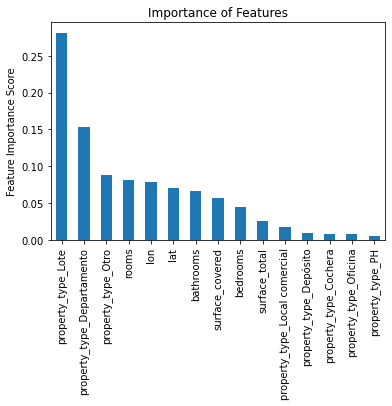

In [59]:
df2[:15].plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

- [The following package provides the tools to implement a LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)

## **LightGBM**

In [31]:
from lightgbm import LGBMRegressor

- [LIGHTGBM blog](https://coderzcolumn.com/tutorials/machine-learning/lightgbm-an-in-depth-guide-python)

In [32]:
a=LGBMRegressor()
gridl = {
        'learning_rate': [0.01, 0.1,0.2,0.4,0.5],
        'max_depth': [10,50,70],
        'n_estimators' : [500,1000],
        'objective': ['regression'],
         'bagging_fraction':[0.1,0.3,0.7,0.9],
         'feature_fraction':[0.1,0.3,0.7,0.9]
    }
lightsearch = GridSearchCV(estimator =a,
                           param_grid = gridl,                         
                           scoring = 'neg_mean_squared_error', 
                           cv = 5,
                           n_jobs = 7,
                           verbose = 1)

light_cv=gsearch.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 125 out of 125 | elapsed:  5.2min finished


In [34]:
df4= pd.Series(light_cv.best_estimator_.feature_importances_, list(data.drop(columns=['price']))).sort_values(ascending=False)

In [33]:
mse(y_test, light_cv.predict(x_test))

441754201199748.75

Text(0, 0.5, 'Feature Importance Score')

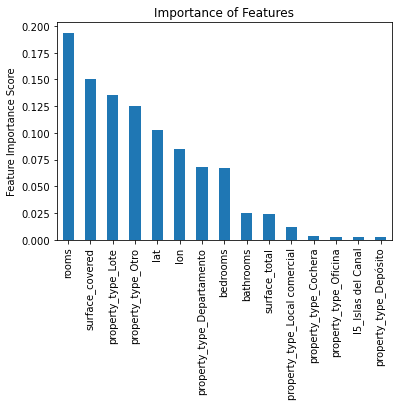

In [35]:
df4[:15].plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

## **Clasification problem**

[metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [36]:
data2=pd.read_csv('diabetes.csv')

In [37]:
x1_train, x1_test, y1_train, y1_test = train_test_split(data2.drop(columns=['Outcome']),data2['Outcome'], test_size=0.10,
                                                    random_state=200,
                                                    shuffle=True)

**CART**

In [38]:
from sklearn.metrics import accuracy_score

In [39]:
from sklearn.tree import DecisionTreeClassifier

In [40]:
CART_clf=DecisionTreeClassifier(max_depth=3).fit(x1_train,y1_train)

In [41]:
y_pred=CART_clf.predict(x1_test)

In [42]:
y_pred

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0], dtype=int64)

In [44]:
accuracy_score(y1_test, y_pred)

0.7792207792207793

**XG boost**

-[Accuracy metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)

In [96]:
from xgboost import XGBClassifier

In [124]:
grid = {
        'learning_rate': [0.01, 0.1,0.2,0.5],
        'max_depth': [20,30,40,50],
        'n_estimators' : [ 500,1000,2000],
        'error': ['logloss']
    }

xgb_clf = XGBClassifier()

gsearch = GridSearchCV(estimator = xgb_clf,
                           param_grid = grid,                         
                           scoring = 'accuracy', 
                           cv = 5,
                           n_jobs = 7,
                           verbose = 1)

xgclf_cv=gsearch.fit(x1_train,y1_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   15.9s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   57.1s
[Parallel(n_jobs=7)]: Done 240 out of 240 | elapsed:  1.2min finished
C:\Users\57320\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:19:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "error" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:19:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [125]:
y_pred2=xgclf_cv.predict(x1_test)

In [126]:
accuracy_score(y1_test, y_pred2)

0.7272727272727273

**LightGBM**

In [116]:
from lightgbm import LGBMClassifier

In [117]:
lghtclf= LGBMClassifier().fit(x1_train,y1_train)

In [118]:
y_pred3=xgclf_cv.predict(x1_test)
accuracy_score(y1_test, y_pred3)

0.7792207792207793

In [134]:
d=LGBMClassifier()
gridl = {
        'learning_rate': [0.01, 0.1,0.2,0.5],
        'max_depth': [10,50,70],
        'n_estimators' : [200,1000],
         'bagging_fraction':[0.1,0.5,0.9],
         'feature_fraction':[0.1,0.5,0.9]
}
lightsearch = GridSearchCV(estimator =d,
                           param_grid = gridl,                         
                           scoring = 'accuracy', 
                           cv = 5,
                           n_jobs = 7,
                           verbose = 1)

lightclf_cv=gsearch.fit(x1_train,y1_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   15.8s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   55.7s
[Parallel(n_jobs=7)]: Done 240 out of 240 | elapsed:  1.1min finished
C:\Users\57320\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:23:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "error" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:23:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [135]:
y_pred4=lightclf_cv.predict(x1_test)
accuracy_score(y1_test, y_pred4)

0.7272727272727273